In [188]:
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, roc_auc_score, recall_score, confusion_matrix

In [170]:
with open("train.json") as f:
    df_train = json.load(f)

df_train=pd.DataFrame(df_train)

In [171]:
with open("test.json") as k:
    df_test = json.load(k)
    
df_test=pd.DataFrame(df_test)

In [4]:
df_train.shape

(49352, 15)

In [5]:
df_test.shape

(74659, 14)

In [6]:
df_train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object')

In [7]:
df_test.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address'],
      dtype='object')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [9]:
df_train.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

In [10]:
df_test.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

**Мы видим, что пропусков в данных нет (что хорошо).**

## Осмотр целевой переменной

In [33]:
# Видно, что классы в целевой переменной несбалансированы. Количество экземпляров класса high в 10 раз меньше, 
# чем количество экземпляров класса low. Это важно будет учесть при выборе параметров модели
distribution=df_train['interest_level'].value_counts()
index=distribution.index
dictionary_of_classes={index[0]:(distribution[0]/distribution.sum())*100, 
              index[1]:(distribution[1]/distribution.sum())*100,
              index[2]:(distribution[2]/distribution.sum())*100}
dictionary_of_classes

{'low': 69.46830928837737,
 'medium': 22.752877289674178,
 'high': 7.778813421948453}

In [4]:
# Функция, заменяющая строковые значения на числовые
def change_to_numeric(string):
    if string=='low':
        return 1
    elif string=='medium':
        return 2
    elif string=='high':
        return 3

In [172]:
# Заменим строковые значения целевой переменной на числовые
df_train['interest_level']=df_train['interest_level'].apply(change_to_numeric)

In [269]:
# Для корректной обработки датасета нужно объединить трейн и тест
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['interest_level'] = 0 # в тесте у нас нет значения interest_level, мы его должны предсказать, поэтому пока просто 
# заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

## Первичный осмотр данных

In [174]:
# Функция для отрисовки гистограмм непрерывных переменных
def first_look(df, column):
    fig, ax = plt.subplots(figsize=(7, 4))
    df[column].hist(ax=ax)
    plt.title(column)
    plt.show()

In [175]:
# Функция для определения межквартильного расстояния
def IQR_outlier(df, column):
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)

In [176]:
# Функция для построения графиков типа boxplot
def get_boxplot(df, column):
    fig, axes = plt.subplots(ncols=2, figsize=(6, 4))

    sns.boxplot(data=df[column], orient="h",
                 palette="Set2", whis=1.5, ax=axes[0]);
    df[column].hist(bins=20, ax=axes[1])
    fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
    plt.title(column)
    plt.show()

**Осмотр числовых признаков**

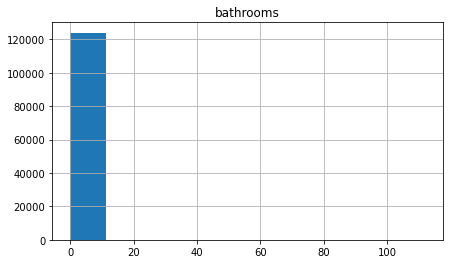

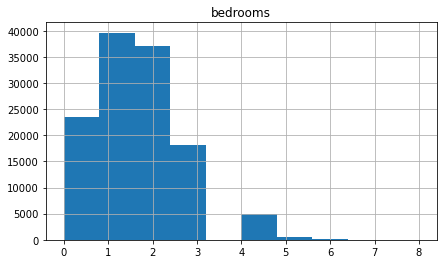

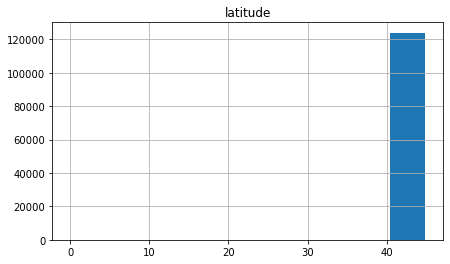

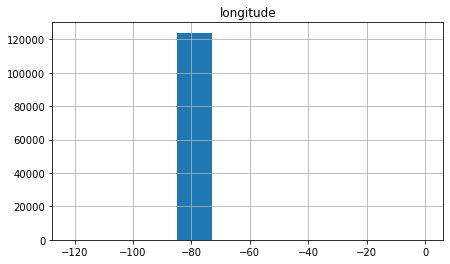

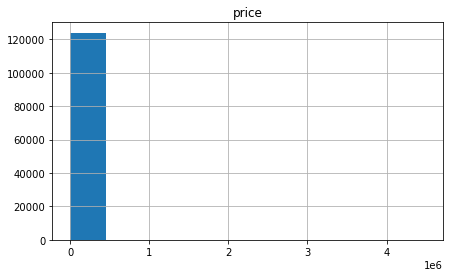

In [177]:
# Числовых признаков пять - bathrooms, bedrooms, latitude, longitude, price. Нарисуем гистограммы этих признаков
columns=['bathrooms','bedrooms',"latitude",'longitude','price']
for col in columns:
    first_look(data, col)

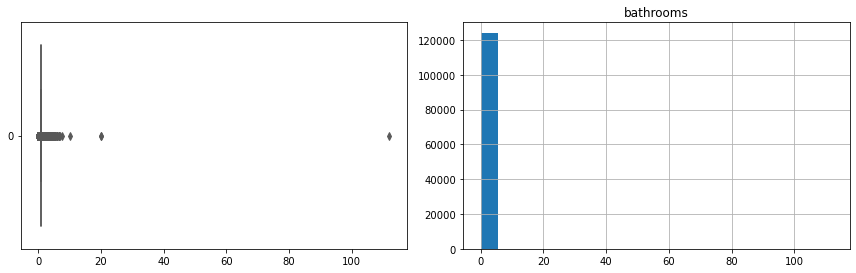

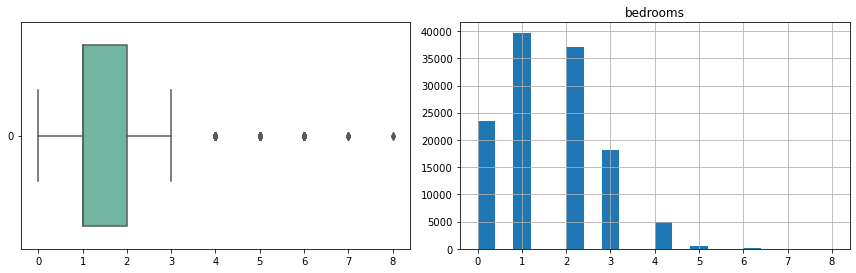

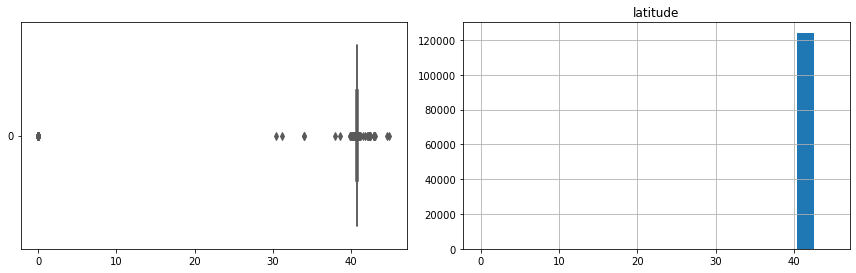

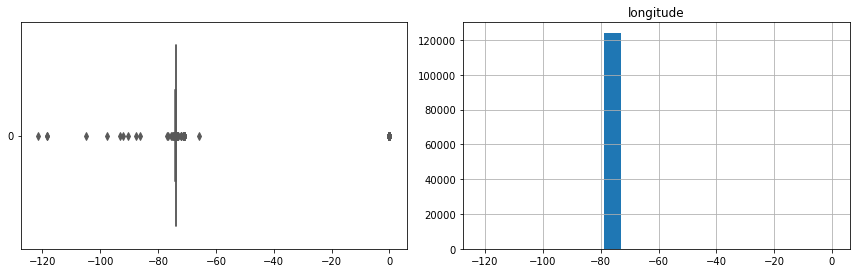

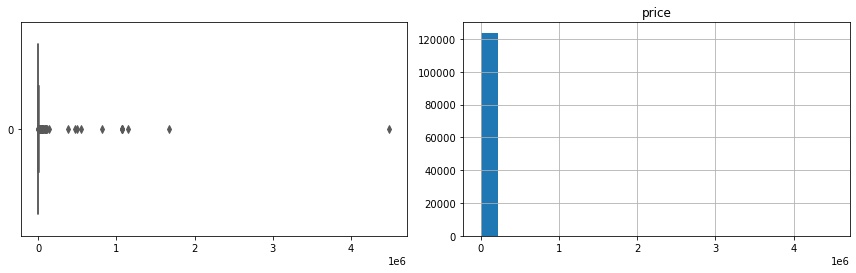

In [12]:
# Нарисуем боксплоты вместе с гистограммами для числовых признаков
for col in columns:
    get_boxplot(data, col)

**Видно, что в данных есть выбросы и/или ошибки. Обработаем их позже, а сейчас пока обучим несколько моделей на необработанных данных**

## Базовая линия

**Построим базовую линию на необработанных данных**

In [270]:
# Выберем из датасета только данные train.json для обучения модели. Ранее мы пометили трейн цифрой 1 в колонке sample
X=data[['bathrooms','bedrooms','latitude','longitude','price','sample']].query('sample==1').drop('sample', axis=1)
y=data[['interest_level','sample']].query('sample==1').drop('sample', axis=1)

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, roc_auc_score, recall_score, confusion_matrix

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
# Напишем функцию, которая будет отображать нам значения всех метрик на тренировочной выборке и на тестовой.
def show_metrics(y_pred_train, Y_train, y_pred_test, Y_test, y_pred_proba_train, y_pred_proba_test,avg='weighted'):
    f1_score_train=f1_score(y_pred_train,Y_train, average=avg)
    f1_score_test=f1_score(y_pred_test,Y_test, average=avg)
    print('[train] f1_score {0:.4f}, [test] f1_score {1:.4f}\n'.format(f1_score_train,f1_score_test))
    precision_score_train=precision_score(y_pred_train,Y_train, average=avg)
    precision_score_test=precision_score(y_pred_test,Y_test, average=avg)
    print('[train] precision_score {0:.4f}, [test] precision_score {1:.4f}\n'.format(precision_score_train,precision_score_test))
    recall_score_train=recall_score(y_pred_train,Y_train, average=avg)
    recall_score_test=recall_score(y_pred_test,Y_test, average=avg)
    print('[train] recall_score {0:.4f}, [test] recall_score {1:.4f}\n'.format(recall_score_train,recall_score_test))
    accuracy_score_train=accuracy_score(y_pred_train,Y_train)
    accuracy_score_test=accuracy_score(y_pred_test,Y_test)
    print('[train] accuracy_score {0:.4f}, [test] accuracy_score {1:.4f}\n'.format(accuracy_score_train,accuracy_score_test))
    roc_auc_score_train=roc_auc_score(Y_train,y_pred_proba_train, average=avg, multi_class='ovr')
    roc_auc_score_test=roc_auc_score(Y_test,y_pred_proba_test, average=avg, multi_class='ovr')
    print('[train] roc_auc_score {0:.4f}, [test] roc_auc_score {1:.4f}\n'.format(roc_auc_score_train,roc_auc_score_test))
    confusion_matrix_train=confusion_matrix(y_pred_train,Y_train)
    confusion_matrix_test=confusion_matrix(y_pred_test,Y_test)
    print('[train] confusion_matrix \n {0}, \n[test] confusion_matrix \n {1}\n'.format(confusion_matrix_train,confusion_matrix_test))

In [187]:
# Напишем функцию, которая будет визуализировать среднюю метрику f1_score_macro на кросс-валидации
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [275]:
# Попробуем использовать логистическую регрессию с параметрами по умолчанию
logreg_baseline=LogisticRegression()

logreg_baseline.fit(X_train,y_train)
y_pred_test=logreg_baseline.predict(X_test)
y_pred_train=logreg_baseline.predict(X_train)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [276]:
y_pred_proba_test=logreg_baseline.predict_proba(X_test)
y_pred_proba_train=logreg_baseline.predict_proba(X_train)

In [277]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.2949, [test] f1_score 0.2937

[train] precision_score 0.3396, [test] precision_score 0.3398

[train] recall_score 0.3360, [test] recall_score 0.3391

[train] accuracy_score 0.6910, [test] accuracy_score 0.6901

[train] roc_auc_score 0.6918, [test] roc_auc_score 0.6870

[train] confusion_matrix 
 [[26950  8610  2837]
 [  493   331   257]
 [    3     0     0]], 
[test] confusion_matrix 
 [[6732 2208  679]
 [ 106   80   66]
 [   0    0    0]]



C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [280]:
# Похоже, переобучения нет. Чтобы проверить это, воспользуемся кросс-валидацией
cv_metrics = cross_validate(logreg_baseline, X, y, cv=5, scoring='f1_macro', return_train_score=True)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[train] F1-score = 0.30 +/- 0.00
[valid] F1-score = 0.29 +/- 0.00


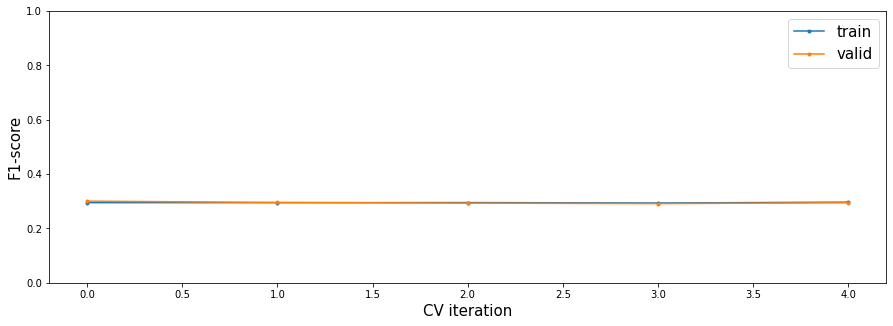

In [281]:
# Выведем график
plot_cv_metrics(cv_metrics)

**Видно, что логистическая регрессия с параметрами по умолчанию очень плохо определяет объекты класса 3 (high) на необработанных данных. Это видно по confusion_matrix. Так как мы берем средневзвешенное значение f1_score_weighted по классам, то за счет большого удельного веса класса 1 (low) мы получаем довольно высокое итоговое значение метрики на кросс-валидации (f1_score_weighted=0.58). Если в функции cross_validate задать параметр scoring='f1_macro'(веса классов не будут учитываться), то значение метрики f1_score_macro будет равно всего 0.29 на тестовом датасете.**

**Сравнение метрик на трейне и на тесте позволяет увидеть, что переобучения модели в данном случае нет.**

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [189]:
# Попробуем использовать случайный лес с параметрами по умолчанию
rfc_baseline=RandomForestClassifier()

rfc_baseline.fit(X_train,y_train)
y_pred_test=rfc_baseline.predict(X_test)
y_pred_train=rfc_baseline.predict(X_train)
y_pred_proba_test=rfc_baseline.predict_proba(X_test)
y_pred_proba_train=rfc_baseline.predict_proba(X_train)

<ipython-input-189-9cb012a3a6ec>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_baseline.fit(X_train,y_train)


In [128]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.8784, [test] f1_score 0.4978

[train] precision_score 0.8590, [test] precision_score 0.4844

[train] recall_score 0.9005, [test] recall_score 0.5222

[train] accuracy_score 0.9194, [test] accuracy_score 0.6949

[train] roc_auc_score 0.9864, [test] roc_auc_score 0.7537

[train] confusion_matrix 
 [[26647  1589   289]
 [  681  7160   313]
 [  118   192  2492]], 
[test] confusion_matrix 
 [[5943 1357  272]
 [ 777  713  270]
 [ 118  218  203]]



In [190]:
# Случайный лес сильно переобучаетсмя. Чтобы проверить это, воспользуемся кросс-валидацией
cv_metrics = cross_validate(rfc_baseline, X, y, cv=5, scoring='f1_macro', return_train_score=True)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

[train] F1-score = 0.88 +/- 0.00
[valid] F1-score = 0.51 +/- 0.01


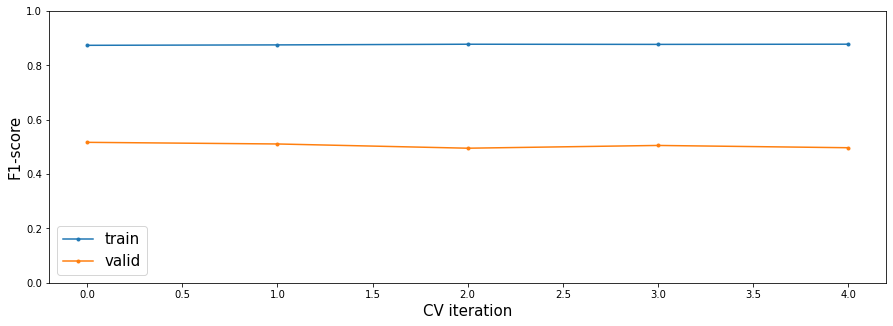

In [191]:
# Выведем график
plot_cv_metrics(cv_metrics)

**Случайный лес с параметрами по умолчанию гораздо лучше справляется с объектами класса 3, чем логистическая регрессия. Но мы также видим, что модель переобучается (метрики на тесте хуже, чем метрики на трейне). При последующем подборе параметров модели нужно будет это учесть (например, ограничить максимальную глубину дерева).**

In [129]:
from sklearn.ensemble import AdaBoostClassifier

In [192]:
# Попробуем использовать AdaBoosting с параметрами по умолчанию
abc_baseline=AdaBoostClassifier()

abc_baseline.fit(X_train,y_train)
y_pred_test=abc_baseline.predict(X_test)
y_pred_train=abc_baseline.predict(X_train)
y_pred_proba_test=abc_baseline.predict_proba(X_test)
y_pred_proba_train=abc_baseline.predict_proba(X_train)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [134]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.4034, [test] f1_score 0.3922

[train] precision_score 0.4038, [test] precision_score 0.3961

[train] recall_score 0.5631, [test] recall_score 0.5502

[train] accuracy_score 0.7085, [test] accuracy_score 0.7038

[train] roc_auc_score 0.7232, [test] roc_auc_score 0.7189

[train] confusion_matrix 
 [[26753  7973  2126]
 [  510   743   493]
 [  183   225   475]], 
[test] confusion_matrix 
 [[6666 2050  505]
 [ 143  181  140]
 [  29   57  100]]



In [193]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(abc_baseline, X, y, cv=5, scoring='f1_macro', return_train_score=True)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[train] F1-score = 0.40 +/- 0.00
[valid] F1-score = 0.40 +/- 0.01


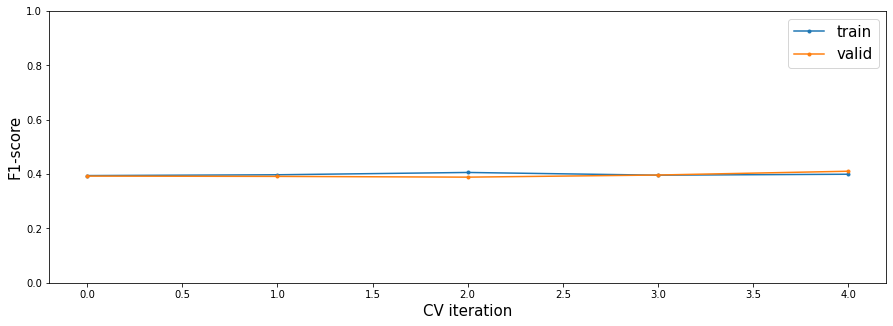

In [194]:
# Выведем график
plot_cv_metrics(cv_metrics)

**В отличие от случайного леса, бустинг практически не переобучается. В дальнейшем попробуем подобрать оптимальные параметры для ада-бустинга для улучшения качества предсказания (например, изменить learning_rate и n_estimators).**

In [135]:
from sklearn.ensemble import GradientBoostingClassifier

In [195]:
# Попробуем использовать градиентный бустинг с параметрами по умолчанию
gbc_baseline=GradientBoostingClassifier()

gbc_baseline.fit(X_train,y_train)
y_pred_test=gbc_baseline.predict(X_test)
y_pred_train=gbc_baseline.predict(X_train)
y_pred_proba_test=gbc_baseline.predict_proba(X_test)
y_pred_proba_train=gbc_baseline.predict_proba(X_train)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [196]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.4172, [test] f1_score 0.3964

[train] precision_score 0.4115, [test] precision_score 0.3978

[train] recall_score 0.6132, [test] recall_score 0.5744

[train] accuracy_score 0.7145, [test] accuracy_score 0.7060

[train] roc_auc_score 0.7744, [test] roc_auc_score 0.7630

[train] confusion_matrix 
 [[26837  7908  2085]
 [  488   884   521]
 [  121   149   488]], 
[test] confusion_matrix 
 [[6669 2041  497]
 [ 146  204  152]
 [  23   43   96]]



In [197]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(gbc_baseline, X, y, cv=5, scoring='f1_macro', return_train_score=True)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[train] F1-score = 0.42 +/- 0.00
[valid] F1-score = 0.41 +/- 0.01


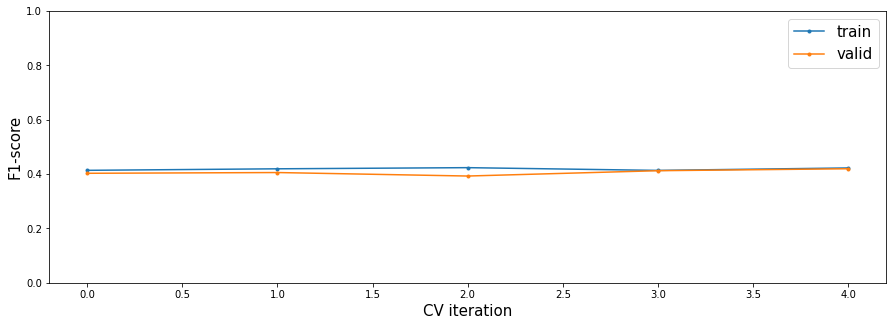

In [198]:
# Выведем график
plot_cv_metrics(cv_metrics)

**Градиентный бустинг также дает неплохой реультат. В целом, на базовой линии бустинг выглядит предпочтительнее, чем логистическая регрессия или случайный лес: не переобучается, лучше определяет объекты 3-го класса, дает более высокие значения метрики f1_score_macro.**

In [282]:
# На данный момент (необработанные данные) результаты следующие (указана усредненная метрика на кросс-валидации для тестовой
# выборки):

# f1_score_weighted=[0.7989,0.7128,0.7863,0.7858]
f1_score_macro=[0.29,0.51,0.40,0.41]
metrics_baseline={'f1_score_macro':f1_score_macro}
pd.DataFrame(metrics_baseline, index=['LogisticRegression','RandomForestClassifier','AdaBoost','GradientBoosing'])

,f1_score_macro
LogisticRegression,0.29
RandomForestClassifier,0.51
AdaBoost,0.40
GradientBoosing,0.41


## Обработка данных и feature engineering

In [283]:
# Заменим явные ошибки в данных на медиану. Это ошибки, т.к. точки с такой широтой/долготой попадают в океан
bathrooms_median=data['bathrooms'].median()
data['bathrooms']=data['bathrooms'].apply(lambda x: bathrooms_median if x>15 else x)

latitude_median=data['latitude'].median()
data['latitude']=data['latitude'].apply(lambda x: latitude_median if x<10 else x)

longitude_median=data['longitude'].median()
data['longitude']=data['longitude'].apply(lambda x: longitude_median if x>-20 or x<-124 else x)

In [284]:
# Прологарифмируем признак price
data['price']=data['price'].apply(lambda x: np.log(x+1))

In [285]:
# Переведем признак created в формат datetime
data['created']=data['created'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")) 

In [286]:
# Извлечем из даты год, месяц, день месяца и день недели
data['year']=data['created'].apply(lambda x: x.year)
data['month']=data['created'].apply(lambda x: x.month)
data['day']=data['created'].apply(lambda x: x.day)
data['day_of_week']=data['created'].apply(lambda x: x.weekday())

In [287]:
# Удалим признак year, т.к. там только одно значение - 2016. Этот признак не несет полезной информации для модели
data.drop(columns=['year'], inplace=True)

In [205]:
# Обработаем признак features. Для начала соберем все features в датасете в один большой список
features=[]
for i in range(len(data)):
    features.extend(data['features'][i])

In [206]:
from collections import Counter

In [207]:
# Создадим список из 15 наиболее часто встречающихся фраз в колонке features, чтобы далее использовать их для создания
# аналога dummy-переменных
most_common_features=[]
for i in Counter(features).most_common(15):
    most_common_features.append(i[0])
most_common_features

['Elevator',
 'Cats Allowed',
 'Hardwood Floors',
 'Dogs Allowed',
 'Doorman',
 'Dishwasher',
 'No Fee',
 'Laundry in Building',
 'Fitness Center',
 'Pre-War',
 'Laundry in Unit',
 'Roof Deck',
 'Outdoor Space',
 'Dining Room',
 'High Speed Internet']

In [208]:
# Функция, которая проверяет, есть ли в данной ячейке элемент из списка most_common_features
def create_dummy_column(some_list):
    if col in some_list:
        return 1
    else:
        return 0   

In [288]:
# Создадаим новые признаки с помощью функции create_dummy_column
for col in most_common_features:
    data[col]=data['features'].apply(create_dummy_column)

In [210]:
# Аналогичным образом обработаем колонку display_address
all_streets=[]

for i in range(len(data)):
    all_streets.append(data['display_address'][i])
    
most_common_streets=[]
for i in Counter(all_streets).most_common(15):
    most_common_streets.append(i[0])
most_common_streets

['Broadway',
 'East 34th Street',
 'Wall Street',
 'Second Avenue',
 'West 37th Street',
 'First Avenue',
 'West Street',
 'John Street',
 'Gold Street',
 'Washington Street',
 'York Avenue',
 'Water Street',
 'Lexington Avenue',
 'East 39th Street',
 'Third Avenue']

In [289]:
# Создадаим новые признаки с помощью функции create_dummy_column
for col in most_common_streets:
    data[col]=data['display_address'].apply(create_dummy_column)

<AxesSubplot:>

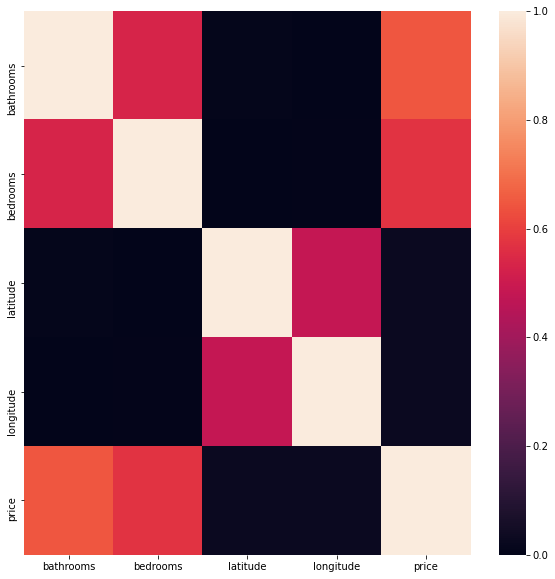

In [212]:
# Построим тепловую карту матрицы корреляций непрерывных признаков. Как и ожидалось, price сильно скоррелирована с количеством 
# bathrooms и bedrooms, а bathrooms и bedrooms скоррелированы между собой
numeric_columns=['bathrooms','bedrooms','latitude','longitude','price']

sns.heatmap(data[numeric_columns].corr().abs(), vmin=0, vmax=1)

**Попробуем применить метод главных компонент к сильно скоррелированным признакам. Найдем матрицу корреляций, посчитаем ее собственные числа и собственные вектора. Добавим новые (нескоррелированные) признаки, старые удалим. Ниже я закомментировала соответствующий кусок кода, т.к. применение метода главных компонент не ведет к улучшению целевой метрики.**

In [20]:
# pca_columns=['bathrooms','bedrooms','price']
# correlation_matrix=data[pca_columns].corr().values

In [21]:
# Находим собственные числа и собственные вектора
# B=np.linalg.eig(correlation_matrix)
# B

(array([2.1707959 , 0.34910944, 0.48009466]),
 array([[-0.58142595, -0.62792777,  0.51734956],
        [-0.55625902, -0.1572359 , -0.81599802],
        [-0.59373375,  0.76222279,  0.25786946]]))

In [22]:
# Центрируем и нормируем признаки
# mean_1=data['bathrooms'].mean()
# len_1=np.linalg.norm(data['bathrooms'])
# data['bathrooms']=data['bathrooms'] - mean_1
# data['bathrooms']=data['bathrooms']/len_1

# mean_2=data['bedrooms'].mean()
# len_2=np.linalg.norm(data['bedrooms'])
# data['bedrooms']=data['bedrooms'] - mean_2
# data['bedrooms']=data['bedrooms']/len_2

# mean_3=data['price'].mean()
# len_3=np.linalg.norm(data['price'])
# data['price']=data['price'] - mean_3
# data['price']=data['price']/len_3

In [23]:
# Вводим новые признаки
# data['pca_component_1']=B[1][0][0]*data['bathrooms']+B[1][1][0]*data['bedrooms']+B[1][2][0]*data['price']
# data['pca_component_2']=B[1][0][1]*data['bathrooms']+B[1][1][1]*data['bedrooms']+B[1][2][1]*data['price']

In [44]:
# data.drop(columns=['bathrooms'], inplace=True)

**Попробуем добавить полиномиальные признаки**

In [74]:
from sklearn.preprocessing import PolynomialFeatures

In [79]:
# Функция для подбора наилучших полиномиальных признаков. Будем комбиринровать колонки с непрерывным
# типом данных по три штуки и создавать на их основе Polynomial Features степени 2, а затем обучать на полученных данных модель
# (для примера возьмем логистическую регрессию).
def find_polynomial_features(df,cols):
    pf=PolynomialFeatures(2)
    poly_features=pf.fit_transform(df[cols])
    index=df.index
    right=pd.DataFrame(poly_features, columns=['1','2','3','4','5','6','7','8','9','10'], index=index)
    right.drop(columns=['1','2','3','4'], inplace=True)
    df=df.join(right, how='inner')
    
    train_data = df.query('sample == 1').drop(['sample'], axis=1)
#     test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)
    y = train_data['interest_level'].values  # наш таргет
    X = train_data.drop(['interest_level','building_id','created','description','display_address','features',
                                                'listing_id','manager_id','photos','street_address'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X1=X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10']].values
    X2=X_test[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10']].values
    
    scaler=RobustScaler()
    X1_transformed=scaler.fit_transform(X1)
    X2_transformed=scaler.transform(X2)
    X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
    X_test[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10']]=X2_transformed
    
    model = LogisticRegression(class_weight='balanced',penalty='none',solver='newton-cg')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    return f1_score(y_test,y_pred, average='macro')

In [76]:
from itertools import combinations

In [80]:
# Переберем в цикле все возможные комбинации колонок с непрерывным типом данных (по 3 штуки из 5-ти). Найдем наилучшую
# комбинацию колонок, которая дает максимальное значение метрики f1_score_macro после обучения модели.
columns=['bathrooms','bedrooms','longitude','latitude','price']
cand=find_polynomial_features(data,['bathrooms','bedrooms','longitude'])
columns_best=['bathrooms','bedrooms','longitude']
for i in combinations(columns,3):    
    f1_score_current=find_polynomial_features(data,list(i))
    print('For the following columns: ',i,' f1_score=', f1_score_current,'\n')
    if f1_score_current>cand:
        cand=f1_score_current
        columns_best=i
print(cand)
print(columns_best)

<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bathrooms', 'bedrooms', 'longitude')  f1_score= 0.46797698544458327 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bathrooms', 'bedrooms', 'latitude')  f1_score= 0.46733164192130233 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bathrooms', 'bedrooms', 'price')  f1_score= 0.47206105083260574 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bathrooms', 'longitude', 'latitude')  f1_score= 0.467610953512559 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bathrooms', 'longitude', 'price')  f1_score= 0.47656675075079685 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bathrooms', 'latitude', 'price')  f1_score= 0.4772764994441807 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bedrooms', 'longitude', 'latitude')  f1_score= 0.46853559668635886 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bedrooms', 'longitude', 'price')  f1_score= 0.4816154252098008 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('bedrooms', 'latitude', 'price')  f1_score= 0.4779709020916893 



<ipython-input-79-40c1bc94d020>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['bathrooms','bedrooms','latitude','longitude','price','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-79-40c1bc94d020>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

For the following columns:  ('longitude', 'latitude', 'price')  f1_score= 0.4789402115387708 

0.4816154252098008
('bedrooms', 'longitude', 'price')


C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


**Найдена наилучшая комбинация колонок - bedrooms, longitude, price.**

In [290]:
# При использовании полиномиальных признаков целевая метрика улучшилась. Добавим эти полиномиальные признаки в наш датасет.
pf=PolynomialFeatures(2)
poly_features=pf.fit_transform(data[['bedrooms','longitude','price']])
index=data.index
right=pd.DataFrame(poly_features, columns=['1','2','3','4','5','6','7','8','9','10'], index=index)
right.drop(columns=['1','2','3','4'], inplace=True)
data=data.join(right, how='inner')

In [213]:
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import f_classif

**Попробуем оценить значимость непрерывных признаков для модели при помощи критерия f_classif**

<AxesSubplot:>

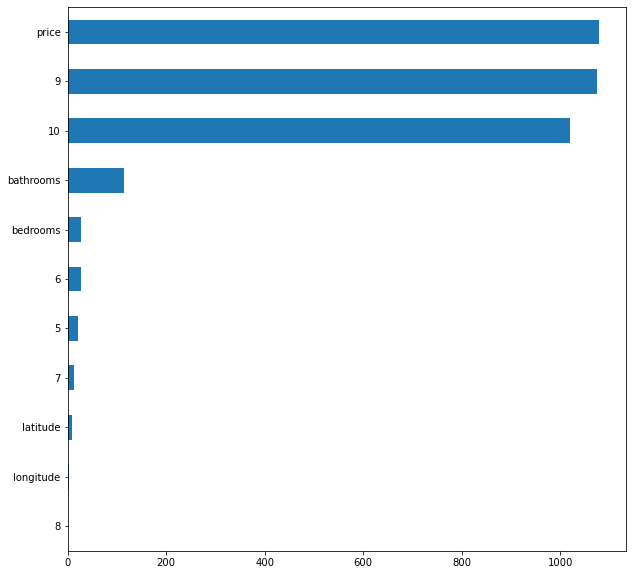

In [291]:
cols=['bathrooms', 'bedrooms','latitude','longitude','price','5','6','7','8','9','10']
imp_num = pd.Series(f_classif(data[cols], data['interest_level'])[0], index = cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [137]:
f_classif(data[cols], data['interest_level'])

(array([ 114.87665648,   26.44912179,    9.98094896,    2.04608421,
        1078.46728698,   23.35978572,   11.09178093,   20.24620357,
          26.44315933,   12.59163497,    1.50926579, 1074.95323873,
        1020.54744936]),
 array([2.75182139e-74, 4.28935512e-17, 1.42119493e-06, 1.05080124e-01,
        0.00000000e+00, 4.14423022e-15, 2.82341215e-07, 4.11677747e-13,
        4.32738944e-17, 3.16287816e-08, 2.09829871e-01, 0.00000000e+00,
        0.00000000e+00]))

**Наибольшую значимость для модели имеет признак price, а также некоторые полиномиальные признаки**

In [292]:
# Подготовим данные для загрузки в модель
train_data=data.query('sample==1').drop(columns=['sample','building_id','created','description','display_address','features',
                                                'listing_id','manager_id','photos','street_address'], axis=1)
test_data=data.query('sample==0').drop(columns=['sample','building_id','created','description','display_address','features',
                                                'listing_id','manager_id','photos','street_address','interest_level'], axis=1)

In [293]:
# Перед загрузкой в модель колонки с непрерывным типом данных нужно обработать с помощью RobustScaler. Я выбрала RobustScaler, 
# т.к. он нечувствителен к выбросам
train_data_numeric=train_data[['bathrooms', 'bedrooms','latitude','longitude','price','month','day','day_of_week','5', '6', '7', '8', '9', '10']]
test_data_numeric=test_data[['bathrooms','bedrooms','latitude','longitude','price','month','day','day_of_week','5', '6', '7', '8', '9', '10']]

scaler=RobustScaler()
train_data_numeric=scaler.fit_transform(train_data_numeric)
test_data_numeric=scaler.transform(test_data_numeric)

In [294]:
# Подготовка данных
train_data_other=train_data.drop(columns=['bathrooms','bedrooms','latitude','longitude','price','month','day','day_of_week',
                                          'interest_level','5', '6', '7', '8', '9', '10'])
test_data_other=test_data.drop(columns=['bathrooms','bedrooms','latitude','longitude','price','month','day','day_of_week','5', '6', '7', '8', '9', '10'])

X=np.hstack([train_data_numeric, train_data_other])
X_valid=np.hstack([test_data_numeric, test_data_other])

y=train_data['interest_level']

In [295]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2,random_state=42)

## Подбор оптимальных параметров модели

**Логистическая регрессия**

In [223]:
# Попробуем для начала использовать логистическую регрессию с параметрами по умолчанию, но теперь уже на обработанных
# данных
logreg_treated=LogisticRegression()

logreg_treated.fit(X_train,y_train)
y_pred_test=logreg_treated.predict(X_test)
y_pred_train=logreg_treated.predict(X_train)

y_pred_proba_test=logreg_treated.predict_proba(X_test)
y_pred_proba_train=logreg_treated.predict_proba(X_train)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [224]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.4087, [test] f1_score 0.4066

[train] precision_score 0.4030, [test] precision_score 0.4018

[train] recall_score 0.5522, [test] recall_score 0.5524

[train] accuracy_score 0.7040, [test] accuracy_score 0.7022

[train] roc_auc_score 0.7662, [test] roc_auc_score 0.7636

[train] confusion_matrix 
 [[26113  7409  1975]
 [ 1207  1351   790]
 [  126   181   329]], 
[test] confusion_matrix 
 [[6499 1877  475]
 [ 322  359  197]
 [  17   52   73]]



In [228]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(logreg_treated, X, y, cv=5, scoring='f1_macro', return_train_score=True)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[train] F1-score = 0.40 +/- 0.00
[valid] F1-score = 0.40 +/- 0.01


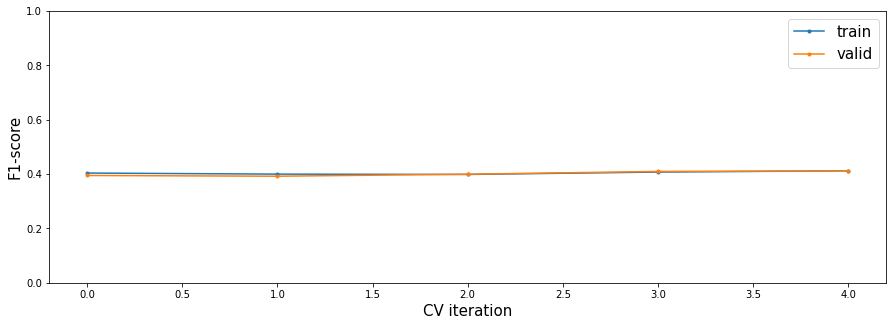

In [230]:
plot_cv_metrics(cv_metrics)

**Мы видим, что обработка данных сильно помогла: логистичекая регрессия с параметрами по умолчанию теперь гораздо лучше определяет объекты 3-го класса. Кроме того, усредненная метрика f1_score_macro улучшилась с 0.29 до 0.40.**

**Для подбора оптимальных параметров модели воспользуемся инструментом GridSearchCV**

In [127]:
from sklearn.model_selection import GridSearchCV

In [128]:
model=LogisticRegression()

# Я специально беру небольшое количество итераций и большее значение tol, чем по умолчанию. Иначе подбор параметров будет 
# работать слишком долго. Если даже алгоритм не сойдется, это можно будет исправить далее с уже найденными параметрами
iter_ = 50
epsilon_stop = 1e-3

param_grid = [ {'penalty': ['l1'], 
      'solver': ['saga'], 
      'class_weight':[None, 'balanced'], 
      'multi_class': ['auto','multinomial'], 
      'max_iter':[iter_],
      'tol':[epsilon_stop]},
      {'penalty': ['l2'], 
       'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
       'class_weight':[None, 'balanced'], 
       'multi_class': ['auto','multinomial'], 
       'max_iter':[iter_],
       'tol':[epsilon_stop]},
      {'penalty': ['none'], 
       'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
       'class_weight':[None, 'balanced'], 
       'multi_class': ['auto','multinomial'], 
      'max_iter':[iter_],
       'tol':[epsilon_stop]} ]

gridsearch = GridSearchCV(model, param_grid, scoring='f1_macro', cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

# печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):       
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
    
# печатаем лучшее значение метрики для gridsearch
print('Наиулчшее значение метрики: ', gridsearch.best_score_)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (stat

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
0.4646063328652977


In [225]:
# Обучим логистическую регрессию с найденными параметрами
logreg_optimized=LogisticRegression(class_weight='balanced',penalty='none',solver='newton-cg')

logreg_optimized.fit(X_train,y_train)
y_pred_test=logreg_optimized.predict(X_test)
y_pred_train=logreg_optimized.predict(X_train)

y_pred_proba_test=logreg_optimized.predict_proba(X_test)
y_pred_proba_train=logreg_optimized.predict_proba(X_train)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [226]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test,avg='macro')

[train] f1_score 0.4849, [test] f1_score 0.4821

[train] precision_score 0.5575, [test] precision_score 0.5558

[train] recall_score 0.4803, [test] recall_score 0.4785

[train] accuracy_score 0.5921, [test] accuracy_score 0.5922

[train] roc_auc_score 0.7599, [test] roc_auc_score 0.7574

[train] confusion_matrix 
 [[17767  2412   360]
 [ 6354  3728   852]
 [ 3325  2801  1882]], 
[test] confusion_matrix 
 [[4456  627   81]
 [1538  939  213]
 [ 844  722  451]]



In [231]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(logreg_optimized, X, y, cv=5, scoring='f1_macro', return_train_score=True)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


[train] F1-score = 0.48 +/- 0.00
[valid] F1-score = 0.48 +/- 0.01


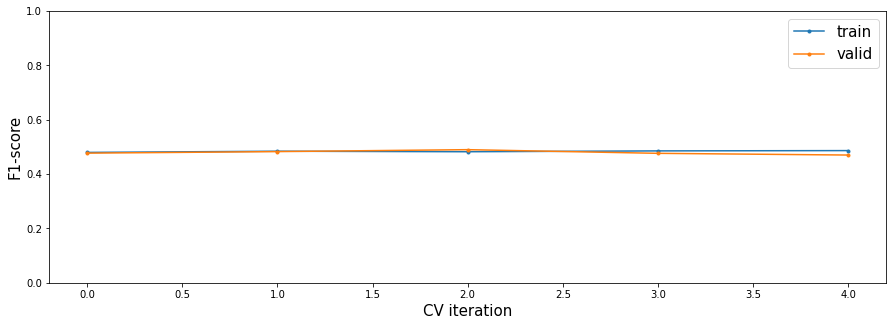

In [232]:
plot_cv_metrics(cv_metrics)

**Дейстивительно, после подбора параметров логистической регрессии метрика f1_score_macro заметно улучшились. Мы видим рост метрики с 0.40 до 0.48 на кросс-валидации.**

In [233]:
# Увеличим количество итераций и снова обучем модель
logreg_optimized=LogisticRegression(class_weight='balanced',penalty='none',solver='newton-cg', max_iter=1000)

logreg_optimized.fit(X_train,y_train)
y_pred_test=logreg_optimized.predict(X_test)
y_pred_train=logreg_optimized.predict(X_train)

y_pred_proba_test=logreg_optimized.predict_proba(X_test)
y_pred_proba_train=logreg_optimized.predict_proba(X_train)

In [235]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(logreg_optimized, X, y, cv=5, scoring='f1_macro', return_train_score=True)

[train] F1-score = 0.48 +/- 0.00
[valid] F1-score = 0.48 +/- 0.01


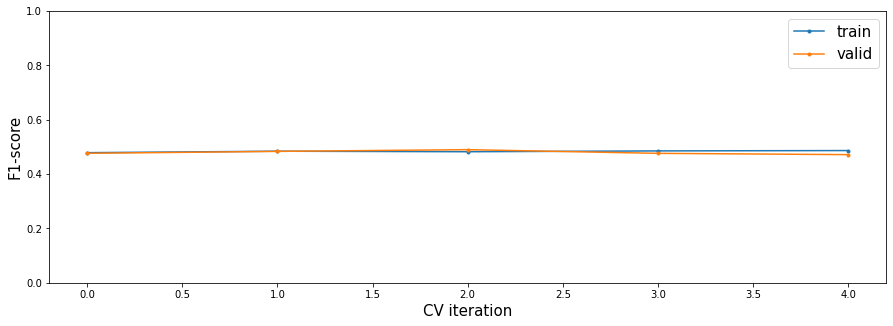

In [236]:
plot_cv_metrics(cv_metrics)

**Метрика не изменилась. Но, по крайней мере, мы избавились от варнингов.**

**Случайный лес**

In [237]:
# Попробуем для начала использовать случайный лес с параметрами по умолчанию на обработанных данных
rfc_treated=RandomForestClassifier()

rfc_treated.fit(X_train,y_train)
y_pred_test=rfc_treated.predict(X_test)
y_pred_train=rfc_treated.predict(X_train)
y_pred_proba_test=rfc_treated.predict_proba(X_test)
y_pred_proba_train=rfc_treated.predict_proba(X_train)

In [142]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.9958, [test] f1_score 0.4753

[train] precision_score 0.9952, [test] precision_score 0.4547

[train] recall_score 0.9964, [test] recall_score 0.5639

[train] accuracy_score 0.9972, [test] accuracy_score 0.7138

[train] roc_auc_score 1.0000, [test] roc_auc_score 0.7862

[train] confusion_matrix 
 [[27418    53    10]
 [   23  8878    10]
 [    5    10  3074]], 
[test] confusion_matrix 
 [[6384 1668  339]
 [ 410  506  250]
 [  44  114  156]]



In [238]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(rfc_treated, X, y, cv=5, scoring='f1_macro', return_train_score=True)

[train] F1-score = 0.99 +/- 0.00
[valid] F1-score = 0.51 +/- 0.01


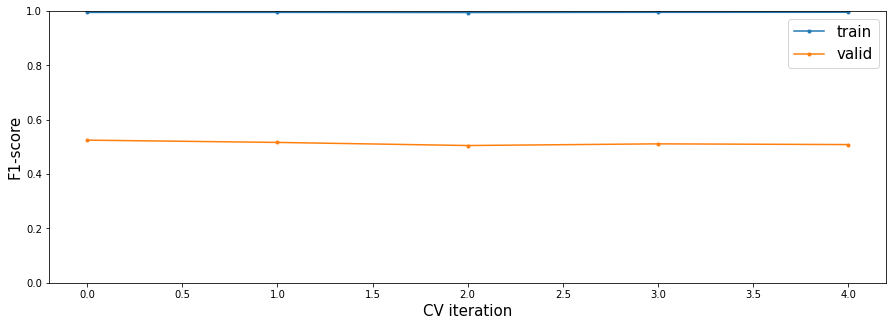

In [239]:
plot_cv_metrics(cv_metrics)

**Метрика на обработанных данных по сравнению с необработанными не изменилась. Кроме того, мы по-прежнему видим сильное переобучение случайного леса.**

**Попробуем побороться с переобучением. Эксперименты показали, что:**
**1. Простое ограничение глубины дерева (max_depth=10) позволяет избавиться от переобучения, но целевая метрика f1_score_macro становится хуже, т.к. деревья получаются недообученными**
**2. Избавиться от переобучения удается с помощью ограничения минимального числа образцов в сплите (min_samples_split=200), но это тоже приводит к уменьшению целевой метрики из-за недообученности деревьев.**

In [240]:
# Возьмем не переобученную модель
rfc_not_overfit=RandomForestClassifier(max_depth=10, n_estimators=1000)

rfc_not_overfit.fit(X_train,y_train)
y_pred_test=rfc_not_overfit.predict(X_test)
y_pred_train=rfc_not_overfit.predict(X_train)
y_pred_proba_test=rfc_not_overfit.predict_proba(X_test)
y_pred_proba_train=rfc_not_overfit.predict_proba(X_train)

In [241]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.5005, [test] f1_score 0.4142

[train] precision_score 0.4669, [test] precision_score 0.4098

[train] recall_score 0.7571, [test] recall_score 0.5896

[train] accuracy_score 0.7475, [test] accuracy_score 0.7154

[train] roc_auc_score 0.8556, [test] roc_auc_score 0.7986

[train] confusion_matrix 
 [[27117  7150  1895]
 [  279  1709   514]
 [   50    82   685]], 
[test] confusion_matrix 
 [[6691 1959  465]
 [ 128  273  182]
 [  19   56   98]]



In [242]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(rfc_not_overfit, X, y, cv=5, scoring='f1_macro', return_train_score=True)

[train] F1-score = 0.50 +/- 0.01
[valid] F1-score = 0.42 +/- 0.01


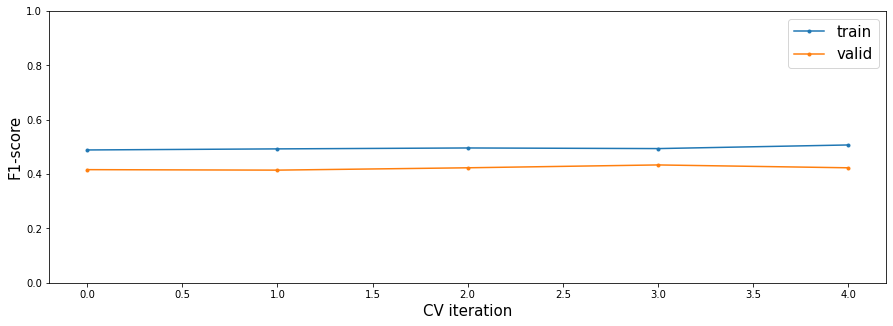

In [243]:
plot_cv_metrics(cv_metrics)

**Таким образом, не переобученная модель случайного леса показывает значение целевой метрики ниже чем у логистической регресии (0.42 по сравнению с 0.48). При таком результате подбирать оптимальные параметры случайного леса с помощью GridSearchCV или RandomizedSearchCV не имеет особого смысла. Лучше выбрать другую модель.**

<AxesSubplot:>

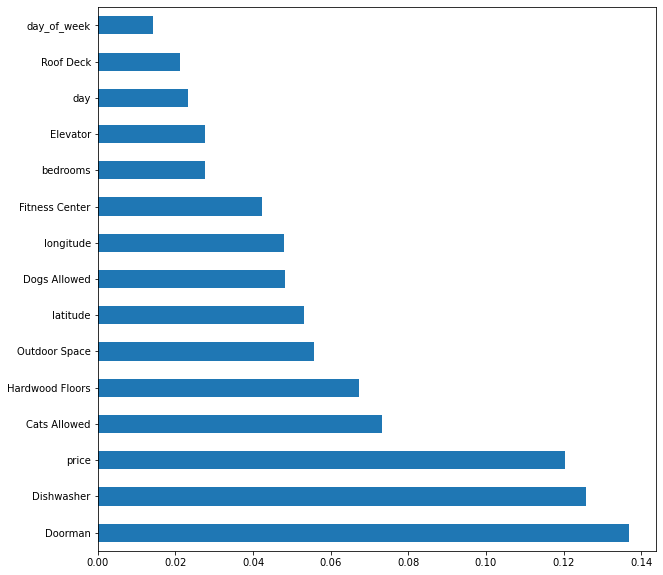

In [100]:
# Выведем наиболее важные признаки для модели случайного леса (не переобученная модель)
columns=['bathrooms','bedrooms','latitude','longitude','price','month','day','day_of_week', 'Elevator',
       'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman',
       'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center',
       'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space',
       'Dining Room', 'High Speed Internet', 'Broadway', 'East 34th Street',
       'Wall Street', 'Second Avenue', 'West 37th Street', 'First Avenue',
       'West Street', 'John Street', 'Gold Street', 'Washington Street',
       'York Avenue', 'Water Street', 'Lexington Avenue', 'East 39th Street',
       'Third Avenue','5', '6', '7', '8', '9', '10']
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(rfc_not_overfit.feature_importances_, index=columns)
feat_importances.nlargest(15).plot(kind='barh')

**Ada бустинг**

In [244]:
# Для начала обучим модель с параметрами по умолчанию на обработанных данных
abc_treated=AdaBoostClassifier()

abc_treated.fit(X_train,y_train)
y_pred_test=abc_treated.predict(X_test)
y_pred_train=abc_treated.predict(X_train)
y_pred_proba_test=abc_treated.predict_proba(X_test)
y_pred_proba_train=abc_treated.predict_proba(X_train)

In [186]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.4474, [test] f1_score 0.4427

[train] precision_score 0.4315, [test] precision_score 0.4278

[train] recall_score 0.5668, [test] recall_score 0.5663

[train] accuracy_score 0.7139, [test] accuracy_score 0.7111

[train] roc_auc_score 0.7628, [test] roc_auc_score 0.7617

[train] confusion_matrix 
 [[26056  7025  1705]
 [ 1201  1625   883]
 [  189   291   506]], 
[test] confusion_matrix 
 [[6484 1790  399]
 [ 326  423  234]
 [  28   75  112]]



In [245]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(abc_treated, X, y, cv=5, scoring='f1_macro', return_train_score=True)

[train] F1-score = 0.45 +/- 0.00
[valid] F1-score = 0.45 +/- 0.01


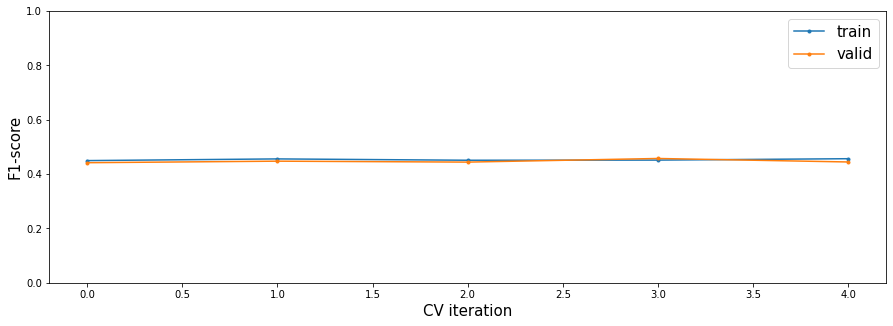

In [246]:
plot_cv_metrics(cv_metrics)

**Мы видим, что обработка данных позволила улучшить целевую метрику f1_score_macro с 0.40 до 0.45. Ада-бустинг при этом не переобучается.**

**Попробуем подобрать оптимальные параметры модели с помощью RandomizedSearchCV.**

In [238]:
# Сетка параметров
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}

In [239]:
# Наша сетка параметров содержит 48 комбинаций. Установим n_iter=10, чтобы случайным образом выбрать 10 комбинаций параметров.
abc=AdaBoostClassifier(random_state=42)
abc_random = RandomizedSearchCV(estimator=abc, param_distributions=param_grid, n_iter=10, scoring='f1_macro',
                                cv=3, verbose=2, random_state=42)
abc_random.fit(X_train,y_train)

best_model=abc_random.best_estimator_
best_parameters=best_model.get_params()
print('Лучшие параметры: ',best_parameters)

best_score=abc_random.best_score_
print('Лучшее значение метрики: {:.4f}'.format(best_score))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...............learning_rate=0.01, n_estimators=750; total time=  42.8s
[CV] END ...............learning_rate=0.01, n_estimators=750; total time=  45.8s
[CV] END ...............learning_rate=0.01, n_estimators=750; total time=  44.8s
[CV] END ..................learning_rate=1, n_estimators=100; total time=   5.7s
[CV] END ..................learning_rate=1, n_estimators=100; total time=   5.6s
[CV] END ..................learning_rate=1, n_estimators=100; total time=   5.7s
[CV] END ...............learning_rate=0.01, n_estimators=500; total time=  29.8s
[CV] END ...............learning_rate=0.01, n_estimators=500; total time=  28.0s
[CV] END ...............learning_rate=0.01, n_estimators=500; total time=  28.5s
[CV] END ..................learning_rate=1, n_estimators=750; total time=  42.5s
[CV] END ..................learning_rate=1, n_estimators=750; total time=  43.7s
[CV] END ..................learning_rate=1, n_es

ValueError: Empty attribute in format string

In [247]:
# Обучим ада-бустинг с найденными параметрами
abc_optimized=AdaBoostClassifier(n_estimators=750, random_state=42)

abc_optimized.fit(X_train,y_train)
y_pred_test=abc_optimized.predict(X_test)
y_pred_train=abc_optimized.predict(X_train)
y_pred_proba_test=abc_optimized.predict_proba(X_test)
y_pred_proba_train=abc_optimized.predict_proba(X_train)

In [248]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.4985, [test] f1_score 0.4829

[train] precision_score 0.4736, [test] precision_score 0.4604

[train] recall_score 0.5897, [test] recall_score 0.5802

[train] accuracy_score 0.7257, [test] accuracy_score 0.7199

[train] roc_auc_score 0.7551, [test] roc_auc_score 0.7377

[train] confusion_matrix 
 [[25771  6399  1377]
 [ 1418  2127   962]
 [  257   415   755]], 
[test] confusion_matrix 
 [[6431 1679  332]
 [ 353  514  252]
 [  54   95  161]]



In [249]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(abc_optimized, X, y, cv=5, scoring='f1_macro', return_train_score=True)

[train] F1-score = 0.50 +/- 0.01
[valid] F1-score = 0.48 +/- 0.01


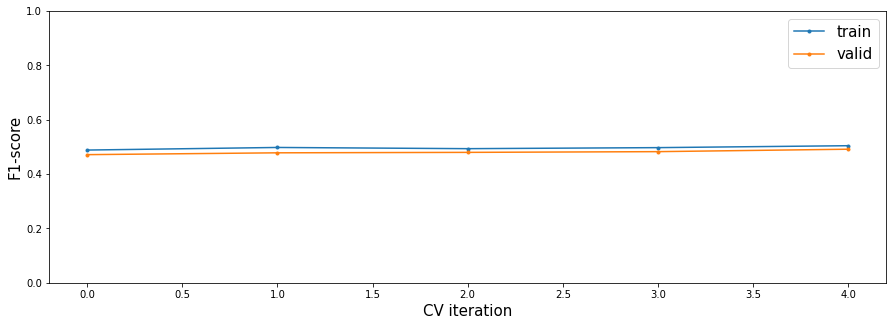

In [250]:
plot_cv_metrics(cv_metrics)

**Ада-бустинг с подобранными параметрами дает значение целевой метрики 0.48 (вместо 0.45 у ада-бустинга с параметрами по умолчанию). Переобучения нет.**

<AxesSubplot:>

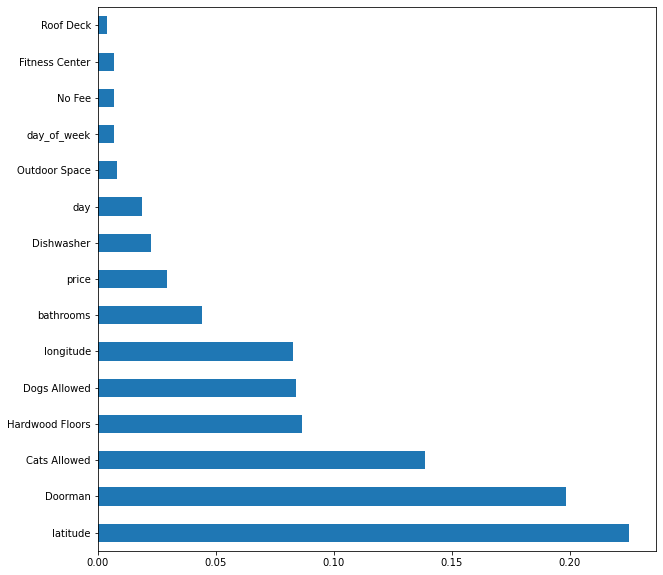

In [296]:
# Выведем наиболее важные признаки для модели ада-бустинга (модель с подобранными параметрами)
columns=['bathrooms','bedrooms','latitude','longitude','price','month','day','day_of_week', 'Elevator',
       'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman',
       'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center',
       'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space',
       'Dining Room', 'High Speed Internet', 'Broadway', 'East 34th Street',
       'Wall Street', 'Second Avenue', 'West 37th Street', 'First Avenue',
       'West Street', 'John Street', 'Gold Street', 'Washington Street',
       'York Avenue', 'Water Street', 'Lexington Avenue', 'East 39th Street',
       'Third Avenue','5', '6', '7', '8', '9', '10']
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(abc_optimized.feature_importances_, index=columns)
feat_importances.nlargest(15).plot(kind='barh')

**Градиентный бустинг**

In [251]:
# Для начала используем градиентный бустинг с параметрами по умолчанию на обработанных данных
gbc_treated=GradientBoostingClassifier()

gbc_treated.fit(X_train,y_train)
y_pred_test=gbc_treated.predict(X_test)
y_pred_train=gbc_treated.predict(X_train)
y_pred_proba_test=gbc_treated.predict_proba(X_test)
y_pred_proba_train=gbc_treated.predict_proba(X_train)

In [252]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.4765, [test] f1_score 0.4482

[train] precision_score 0.4514, [test] precision_score 0.4311

[train] recall_score 0.6390, [test] recall_score 0.6051

[train] accuracy_score 0.7294, [test] accuracy_score 0.7177

[train] roc_auc_score 0.8148, [test] roc_auc_score 0.8016

[train] confusion_matrix 
 [[26311  6839  1596]
 [ 1028  1929   942]
 [  107   173   556]], 
[test] confusion_matrix 
 [[6545 1810  392]
 [ 273  428  242]
 [  20   50  111]]



In [253]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(gbc_treated, X, y, cv=5, scoring='f1_macro', return_train_score=True)

[train] F1-score = 0.47 +/- 0.00
[valid] F1-score = 0.46 +/- 0.01


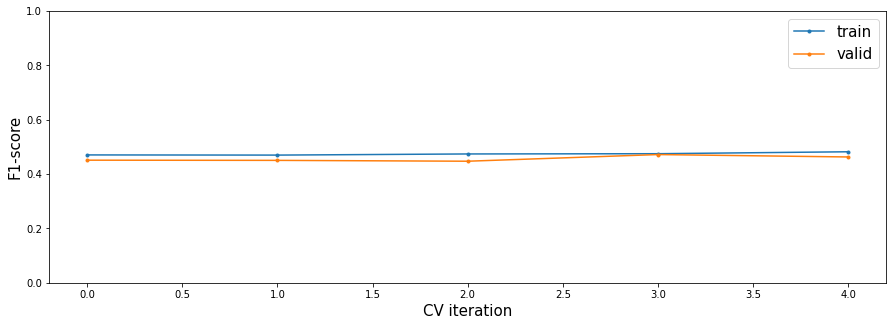

In [254]:
plot_cv_metrics(cv_metrics)

**Мы видим, что обработка данных позволила улучшить целевую метрику f1_score_macro с 0.41 до 0.46. Градиентный бустинг при этом не переобучается.**

**Попробуем подобрать оптимальные параметры модели с помощью RandomizedSearchCV.**

In [139]:
# Сетка параметров
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750],
              'max_depth':[5,6,7,8,9,10,11,12,13,14,15]}

In [140]:
# Наша сетка параметров содержит 528 комбинаций. Установим n_iter=10, чтобы случайным образом выбрать 10 комбинаций параметров.
# Этого объективно мало, но иначе подбор параметров будет длиться слишком долго
gbc=GradientBoostingClassifier(random_state=42)
gbc_random = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid, n_iter=10, scoring='f1_macro',
                                cv=3, verbose=2, random_state=42)
gbc_random.fit(X_train,y_train)

best_model=gbc_random.best_estimator_
best_parameters=best_model.get_params()
print('Лучшие параметры: ',best_parameters)

best_score=gbc_random.best_score_
print('Лучшее значение метрики: {:.4f}'.format(best_score))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.0001, max_depth=13, n_estimators=1500; total time=54.3min
[CV] END learning_rate=0.0001, max_depth=13, n_estimators=1500; total time=57.9min
[CV] END learning_rate=0.0001, max_depth=13, n_estimators=1500; total time=57.7min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=750; total time=16.5min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=750; total time=16.3min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=750; total time=16.1min
[CV] END learning_rate=1e-05, max_depth=5, n_estimators=1500; total time=15.5min
[CV] END learning_rate=1e-05, max_depth=5, n_estimators=1500; total time=15.3min
[CV] END learning_rate=1e-05, max_depth=5, n_estimators=1500; total time=15.3min
[CV] END ..learning_rate=0.1, max_depth=13, n_estimators=250; total time= 7.6min
[CV] END ..learning_rate=0.1, max_depth=13, n_estimators=250; total time= 7.8min
[CV] END ..learning_rate=0.1, max_depth=13

In [255]:
# Найдены оптимальные параметры градиентного бустинга.
gbc_optimized=GradientBoostingClassifier(learning_rate=0.1, n_estimators=750, max_depth=10)

gbc_optimized.fit(X_train,y_train)
y_pred_test=gbc_optimized.predict(X_test)
y_pred_train=gbc_optimized.predict(X_train)
y_pred_proba_test=gbc_optimized.predict_proba(X_test)
y_pred_proba_train=gbc_optimized.predict_proba(X_train)

In [256]:
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.9958, [test] f1_score 0.5136

[train] precision_score 0.9961, [test] precision_score 0.4947

[train] recall_score 0.9955, [test] recall_score 0.5532

[train] accuracy_score 0.9972, [test] accuracy_score 0.7153

[train] roc_auc_score 1.0000, [test] roc_auc_score 0.7972

[train] confusion_matrix 
 [[27414    54     4]
 [   21  8872     5]
 [   11    15  3085]], 
[test] confusion_matrix 
 [[6128 1371  220]
 [ 631  734  326]
 [  79  183  199]]



In [297]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(gbc_optimized, X, y, cv=5, scoring='f1_macro', return_train_score=True)

[train] F1-score = 0.99 +/- 0.00
[valid] F1-score = 0.52 +/- 0.01


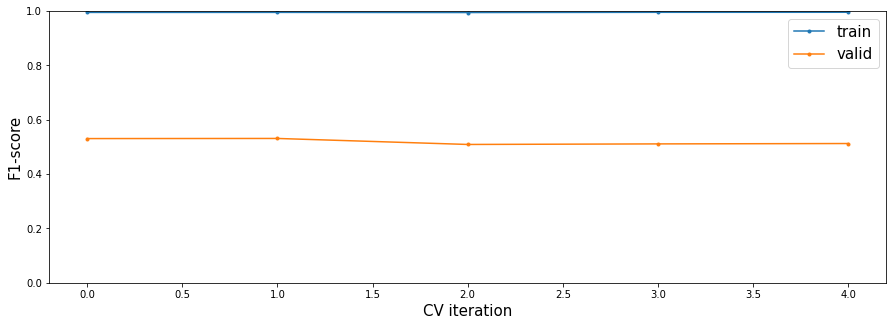

In [298]:
plot_cv_metrics(cv_metrics)

**Как видно из метрик на кросс-валидации, градиентный бустинг с найденными параметрами очень сильно переобучается. Попробуем вручную побороться с переобучением: вернем максимальную глубину дерева к дефолтному значению 3, добавим subsample=0.5, уменьшим learning_rate.**

In [257]:
# Борьба с переобучением
gbc_not_overfit=GradientBoostingClassifier(learning_rate=0.05, n_estimators=750, subsample=0.5)

gbc_not_overfit.fit(X_train,y_train)
y_pred_test=gbc_not_overfit.predict(X_test)
y_pred_train=gbc_not_overfit.predict(X_train)
y_pred_proba_test=gbc_not_overfit.predict_proba(X_test)
y_pred_proba_train=gbc_not_overfit.predict_proba(X_train)

In [258]:
# Выведем метрики
show_metrics(y_pred_train,y_train,y_pred_test,y_test,y_pred_proba_train,y_pred_proba_test, avg='macro')

[train] f1_score 0.5688, [test] f1_score 0.5041

[train] precision_score 0.5275, [test] precision_score 0.4763

[train] recall_score 0.6947, [test] recall_score 0.6122

[train] accuracy_score 0.7601, [test] accuracy_score 0.7310

[train] roc_auc_score 0.8511, [test] roc_auc_score 0.8181

[train] confusion_matrix 
 [[26039  5650  1142]
 [ 1280  3074  1055]
 [  127   217   897]], 
[test] confusion_matrix 
 [[6426 1581  277]
 [ 373  631  309]
 [  39   76  159]]



In [299]:
# Посчитаем метрики на кросс-валидации
cv_metrics = cross_validate(gbc_not_overfit, X, y, cv=5, scoring='f1_macro', return_train_score=True)

[train] F1-score = 0.57 +/- 0.00
[valid] F1-score = 0.51 +/- 0.00


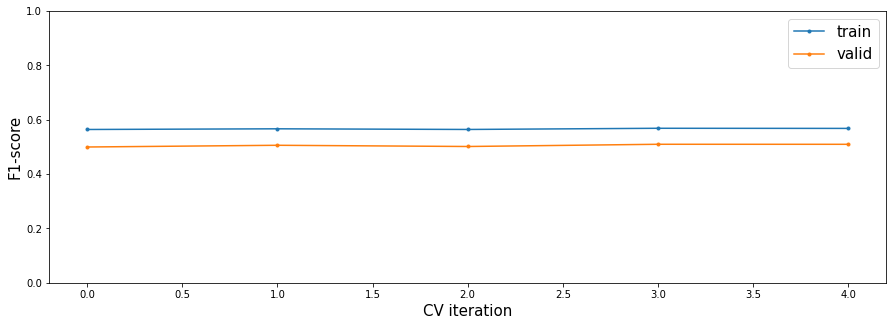

In [300]:
plot_cv_metrics(cv_metrics)

**Таким образом, градиентный бустинг показал наилучший результат из всех моделей. Не переобученная модель дает значение целевой метрики f1_score_macro=0.51.**

<AxesSubplot:>

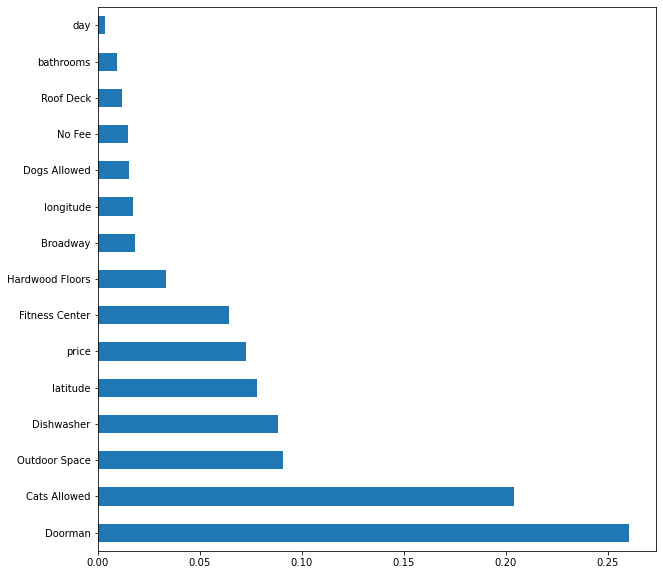

In [98]:
# Выведем наиболее важные признаки для модели градиентного бустинга (модель с параметрами по умолчанию)
columns=['bathrooms','bedrooms','latitude','longitude','price','month','day','day_of_week', 'Elevator',
       'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman',
       'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center',
       'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space',
       'Dining Room', 'High Speed Internet', 'Broadway', 'East 34th Street',
       'Wall Street', 'Second Avenue', 'West 37th Street', 'First Avenue',
       'West Street', 'John Street', 'Gold Street', 'Washington Street',
       'York Avenue', 'Water Street', 'Lexington Avenue', 'East 39th Street',
       'Third Avenue','5', '6', '7', '8', '9', '10']
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(gbc_treated.feature_importances_, index=columns)
feat_importances.nlargest(15).plot(kind='barh')

## Выводы

**1. Для решения данной задачи были испробованы 4 модели: логистическая регрессия, случайный лес, ада-бустинг и градиентный бустинг. Было показано, что случайный лес плохо подходит для решения данной задачи, т.к. происходит переобучение. При борьбе с переобучением целевая метрика снижается и становится хуже, чем у всех остальных моделей.**

**2. Обработка данных значительно улучшает целевую метрику. Наилучшие результаты на обработанных данных были получены для  градиентного бустинга (f1_score_macro=0.51 на кросс-валидации). Сводную таблицу результатов см. в датафрейме ниже.**

In [301]:
# f1_score_weighted=[0.5372,0.8083,0.7654,0.7760]
f1_score_macro=[0.48,0.42,0.48,0.51]
metrics_baseline={'f1_score_macro':f1_score_macro}
pd.DataFrame(metrics_baseline, index=['LogisticRegression','RandomForestClassifier','AdaBoost','GradientBoosing'])

,f1_score_macro
LogisticRegression,0.48
RandomForestClassifier,0.42
AdaBoost,0.48
GradientBoosing,0.51


**3. Обработка данных включает в себя удаление ошибок в данных и feature engineering. В ходе feature engineering были получены 39 дополнительных признаков (включая dummy-признаки и полиномиальные признаки).**

**4. Применение метода главных компонент к сильно скоррелированным признакам по-разному влияет на модели. Логистическая регрессия и ада-бустинг реагируют ухудшением метрики. Для градиентного бустинга и случайного леса наблюдается незначительное повышение метрики. Логистическая регрессия также плохо реагирует на простое удаление одного из сильно скоррелированных признаков.**

**5. Добавление полиномиальных признаков по-разному сказывается на разных моделях. Для логистической регрессиии метрика увеличивается. Для ада-бустинга метрика тоже увеличивается, но не так значительно. Для градиентного бустинга метрика ухудшается. Для случайного леса метрика увеличивается.**

**6. После проведения всех расчетов градиентный бустинг дает самое высокое значение метрики f1_score_macro на кросс-валидации, но при этом сильно переобучается. С переобучением удается справиться путем ограничения глубины дерева, уменьшения learning_rate и задания subsample=0.5. Итоговая метрика (при не переобученном градиентном бустинге) равна 0.51.**